# cIB method
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
try:
    plt.style.use("jupyter")
except OSerror:
    print("Using default ploting style")

In [14]:
def update_cIB(x, X, u0, V, dx, dt=1, rho=1):
    u_n = u0
    for i in range(1):
        # first step
        u_1 = u_n + dt*ns.r(u_n)
        u_2 = u_1 + dt*get_f(x, X, u_1, V, dx, dt, rho)

        f_c = np.zeros_like(u_2)

        for _ in range(10):

            sigma = ns.div(u_2, dx) - ns.div(f_c, dx)

            p = ns.solve_pressure(np.ones_like(sigma), sigma, dx)

            f_c = ns.grad(p, dx) - to_face(grad_c(p, dx))

        u_n = u_2 - dt/rho*(ns.grad(p, dx))
    
    return p, u_2, sigma, u_n


def to_face(f):
    cell_c = np.zeros_like(f)
    cell_c[1:] = 0.5*(f[:-1] + f[1:])
    cell_c[0] = 0.5*(f[-1]+f[0])
    return cell_c


def bing_matrix_incersion(u0):
    # if flow is initial at rest this is zero.
    return u0


def grad_c(f, dx, m=4, kappa=1, eps=1e-6, c=5):
    grad = np.zeros(len(f))
    for i in range(2, len(f)-2):
        b1 = 13./12*(f[i-2] - 2*f[i-1] + f[i])**2 + 0.25*(3*f[i-2]-4*f[i-1]+f[i])**2
        b2 = 13./12*(f[i-1] - 2*f[i] + f[i+1])**2 + 0.25*(f[i-1]-f[i+1])**2
        b3 = 13./12*(f[i] - 2*f[i+1] + f[i+2])**2 + 0.25*(3*f[i]-4*f[i+1]+f[i+2])**2
        psi1 = c/(eps + b1)**m
        psi2 = c*kappa/(eps + b2)**m
        psi3 = c/(eps + b3)**m
        w1 = psi1 / (psi1+psi2+psi3)
        w2 = psi2 / (psi1+psi2+psi3)
        w3 = psi3 / (psi1+psi2+psi3)
        df1 = (3*f[i]-4*f[i-1]+f[i-2]) / (2*dx)
        df2 = (f[i+1] - f[i-1]) / (2*dx)
        df3 = (-3*f[i]+4*f[i+1]-f[i+2]) / (2*dx)
        grad[i] = w1*df1 + w2*df2 + w3*df3
    
    # boundary point at threated with forward and backward stencils
    grad[:2] = (-3*f[ :2]+4*f[1:3]-f[2:4]) / (2*dx)
    grad[-2:]=  (3*f[-2:]-4*f[-3:-1:]+f[-4:-2]) / (2*dx)
    
    return grad
    
    
def kernel(r):
    return np.where(abs(r)<=.5, .75-r**2, np.where(abs(r)<=1.5,.5*(2.25-3*abs(r)+r**2), 0))

def Ic(x, X, dx, u):
#     interpolate Eulerian velocity on Lagrangian interface
    return np.sum(u*kernel((X - x)/dx))

def Sc(x, X, F, ds=1):
    return kernel((X - x)/dx)*ds*F

def get_f(x, X, u, V, dx, dt, rho):
    # interpolate to Lagrangian point
    Ur = Ic(x, X, dx, u)
    # compute Lagrangian force density
    F = rho/dt*(V - Ur)
    return Sc(x, X, F) # extrapolate to Eulerian points

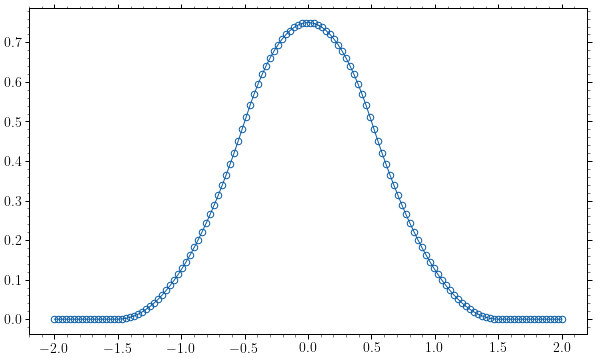

In [16]:
N = 128
x, dx = np.linspace(-2, 2, N, retstep=True)
X = 0.
V = 1
u0 = np.ones_like(x)
plt.plot(x, kernel((X-x)), "-o");

In [17]:
assert np.isclose(Ic(x, X, dx, u0), 1.), "Interpolated velocity should be 1"

In [18]:
assert np.allclose(get_f(x, X, u0, V, dx, 1, 1), 0.), "forcing should be zero"

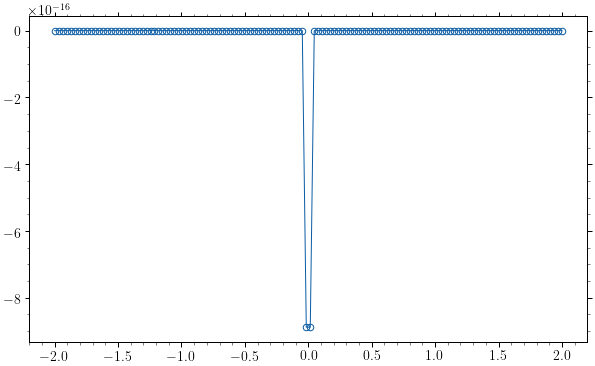

In [19]:
plt.plot(x, get_f(x, X, u0, V, dx, 1, 1), "-o");

Interface at X: 0.00
L inf: 9.717e-01


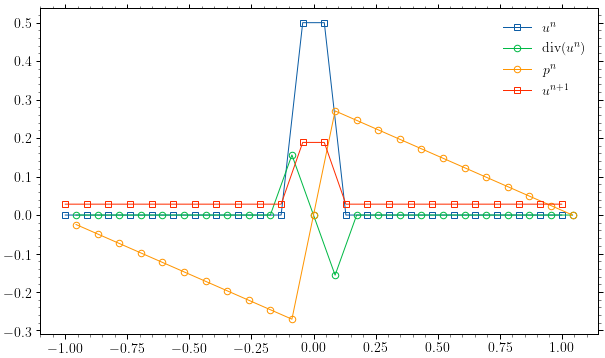

In [20]:
N = 24
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.
V = 1
u0 = np.zeros_like(x)
dt = 1.

p, us, sigma, u_n =  update_cIB(x, X, u0, V, dx, 1, 1)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))
plt.plot(x, us, '-s', label=r"$u^n$")
plt.plot(xs, sigma*0.04, '-o', label=r"div($u^n$)")
plt.plot(xs, 10*p, '-o', label=r"$p^n$")
plt.plot(x, u_n, '-s', label=r"$u^{n+1}$")
plt.legend();